<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# autoreload updated and newly installed packages
# without having to restart Jupyter kernel
%load_ext autoreload
%autoreload 2
# Some little interaction with matplotlib
%matplotlib inline                
# Avoid using Jedi for faster autocomplete (tab)
%config Completer.use_jedi = False

In [2]:
# Standard imports
import datetime
import platform
import os
import sys
from typing import List
# Non-standard imports
import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import plotly.graph_objs as go
from pydantic import ValidationError
# py-fatigue import
import py_fatigue as pf
# Paths of this tutorial and of the data
TUTORIAL_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(TUTORIAL_PATH, "Data")
if not TUTORIAL_PATH in sys.path:
    sys.path.append(TUTORIAL_PATH)
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
print(f"Platform: {platform.platform()}")
print(f"Python version: {sys.version}")
print(f"py-fatigue version: {pf.styling.TermColors.CBOLD}{pf.__version__}")

print(f"\
{pf.styling.TermColors.CBOLD}\
{pf.styling.TermColors.CBLUE}")
      
print(f"DATA_PATH = {DATA_PATH}")
print(f"TUTORIAL_PATH = {TUTORIAL_PATH}")

print(f"{pf.styling.TermColors.CEND}")

Platform: Linux-6.8.0-52-generic-x86_64-with-glibc2.2.5
Python version: 3.8.15 (default, Nov  6 2022, 02:12:40) 
[Clang 14.0.3 ]
py-fatigue version: 1.2.1

DATA_PATH = /home/pietro.dantuono@24SEA.local/Projects/MAXWind/py_fatigue/Data
TUTORIAL_PATH = /home/pietro.dantuono@24SEA.local/Projects/MAXWind/py_fatigue



In [4]:
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["font.family"] = ["sans"]
plt.rcParams["font.size"] = 10
plt.rcParams["lines.markersize"] = 3
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.color"] = "#DDDDDD"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelleft"] = True

In [5]:
# pf.ParisCurve??

In [6]:
SIF = np.linspace(1,2500, 300)
SLOPE_1 = np.array([2.88, 8.16])
INTERCEPT_1 = np.array([1.21E-16, 3.98E-29])
SLOPE_2 = np.array([8.16, 2.88])
INTERCEPT_2 = np.array([1.21E-26, 3.98E-13])
SLOPE_3 = np.array([8.16])
INTERCEPT_3 = np.array([1.21E-26])
THRESHOLD = 75.
CRITICAL = 2000.

In [7]:
# SN curves definition
pc_1 = pf.ParisCurve(slope=SLOPE_1, intercept=INTERCEPT_1, norm="The norm",
                     environment="Environment", curve="nr. 1")
pc_2 = pf.ParisCurve(slope=SLOPE_1, intercept=INTERCEPT_1,threshold=THRESHOLD,
                     critical=CRITICAL, norm="The norm",
                     environment="Environment", curve="nr. 2")

In [8]:
# SN curves definition
pc_3 = pf.ParisCurve(slope=SLOPE_3, intercept=INTERCEPT_3, norm="The norm",
                     environment="Environment", curve="nr. 3")
pc_4 = pf.ParisCurve(slope=SLOPE_2, intercept=INTERCEPT_2,threshold=THRESHOLD,
                     critical=CRITICAL, norm="The norm",
                     environment="Environment", curve="nr. 4")

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12, 8))
pc_1.plot(fig=fig, ax=axs[0],)
pc_3.plot(fig=fig, ax=axs[0],)
pc_2.plot(fig=fig, ax=axs[1],)
pc_4.plot(fig=fig, ax=axs[1],)
axs[0].legend()
axs[1].legend()
plt.show()

## Crack propagation analysis

### Constant load

In [10]:
max_ = 150
scale_ = [1, 2/3, 4/7, 1/2, 3/7]
_scale = scale_[0]

#### Divided cycles

In [11]:
cd = pf.CycleCount(
    count_cycle=np.ones(10000000),
    stress_range=max_ * np.ones(10000000),
    mean_stress=np.zeros(10000000)
)

#### Clustered cycles

In [12]:
cc = pf.CycleCount(
    count_cycle=np.array([10000000.]),
    stress_range=np.array([max_]),
    mean_stress=np.array([0])
)

### Analytical solution

In [13]:
# Renaming Paris constants
m  = slope = pc_3.slope[0]
C  = intercept = pc_3.intercept[0]
Δσ = scf = max_ * _scale
Y  = 1
aⁱ = initial_size = 1
aᶠ = 1e1000
π  = np.pi

In [14]:
# analytical = 2 / (2 - slope) / intercept * np.pi ** (-slope / 2) \
#     * scf ** (-slope) * (-(initial_size ** (1 - slope / 2)))
# print("Analytically integrated Nᶠ:", int(analytical))
Nᶠ = 2 / (2 - m) / C * π ** (-m / 2) * (Y * Δσ) ** (-m) \
    * (- aⁱ ** (1 - m / 2)) if m != 2 else \
    1 / (C * π * (Y * Δσ) ** m) * np.log(aᶠ/aⁱ)
print("Analytically integrated Nᶠ:", int(Nᶠ))

Analytically integrated Nᶠ: 439934


### Numerical solution

#### Geometry

In [15]:
geo = pf.geometry.InfiniteSurface(initial_depth=1.)
geo

InfiniteSurface(
  _id=INF_SUR_00,
  initial_depth=1.0,
)

#### Crack growth

In [17]:
cg = pf.damage.crack_growth.get_crack_growth(
    cc * _scale, pc_3, geo
)
print(f"Cycles to failure: {int(cg.final_cycles)}")

Crack size increased by more than 10x in the last iteration. Stopping calculation.
Cycles to failure: 439944


In [18]:
plt.loglog(np.cumsum(cg.count_cycle)[:439944], cg.crack_depth[:439944])

In [20]:
time = pf.testing.get_sampled_time(10, 1000000)

In [21]:
data = pf.testing.get_random_data(t=time, range_=250)

In [22]:
plt.plot(time, data, c="k", lw=0.5)
plt.xlabel("Time, s")
plt.ylabel("Stress, MPa")
plt.show()

In [23]:
cc = pf.CycleCount.from_timeseries(data=data, time=time, range_bin_width=1.25, mean_bin_width=1.25, name="Signal")

In [24]:
cc

In [25]:
# cc.plot_histogram()

In [26]:
# cg = pf.crack_growth.get_crack_growth(cc, pc_2, 15.)

In [27]:
# cg.crack_size[-1]

In [28]:
# plt.loglog(np.cumsum(cc.count_cycle[:len(cg.crack_size)]), cg.crack_size[1:])

In [29]:
# cg.get_knees_sif

𝜋m∕2 (m∕2 − 1) C(gΔ𝜎i)m ̂ Ni

In [30]:
pc = pf.ParisCurve(intercept=pc_3.intercept[0], slope=pc_3.slope[0])  #, critical=350, threshold=230)
# pc = pf.ParisCurve(intercept=1e-20, slope=4.1)  #, critical=350, threshold=230)
# pc = pf.ParisCurve(intercept=2e-15, slope=5.1)  #, critical=350, threshold=230)
# pc = pf.ParisCurve(intercept=1e-7, slope=2.000001)  #, critical=350, threshold=230)

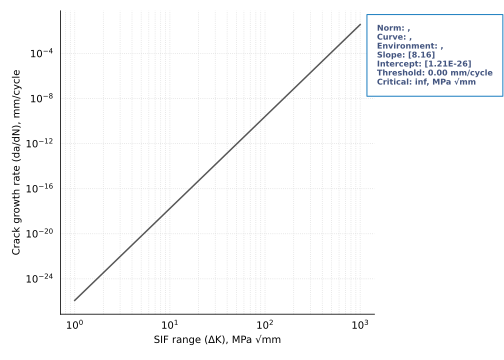

In [31]:
pc

In [32]:
max_ = 1000
data = np.empty((3000000,))
data[::2] = max_ / 2
data[1::2] = - max_ / 2

In [33]:
cc = pf.CycleCount(
    count_cycle=np.ones(10000000),
    stress_range=max_ * np.ones(10000000),
    mean_stress=np.zeros(10000000)
)

In [34]:
cc

In [35]:
scale_ = [1, 2/3, 4/7, 1/2, 3/7]
scale_ = scale_[-1]
# Renaming Paris constants
m  = slope = pc.slope[0]
C  = intercept = pc.intercept[0]
Δσ = scf = max_ * scale_ 
Y  = 1
aⁱ = initial_size = 1
aᶠ = 1e1000
π  = np.pi

In [36]:
analytical = 2 / (2 - slope) / intercept * np.pi ** (-slope / 2) \
    * scf ** (-slope) * (-(initial_size ** (1 - slope / 2)))
print("Analytically integrated Nᶠ:", int(analytical))

Analytically integrated Nᶠ: 83


In [37]:
Nᶠ = 2 / (2 - m) / C * π ** (-m / 2) * (Y * Δσ) ** (-m) \
    * (- aⁱ ** (1 - m / 2)) if m != 2 else \
    1 / (C * π * (Y * Δσ) ** m) * np.log(aᶠ/aⁱ)
print("Analytically integrated Nᶠ:", int(Nᶠ))

Analytically integrated Nᶠ: 83


In [38]:
Nᶠ = 2 / (2 - m) / C * π ** (-m / 2) * (Y * Δσ) ** (-m) \
    * (aᶠ ** (1 - m / 2) - aⁱ ** (1 - m / 2)) if m != 2 else \
    1 / (C * π * (Y * Δσ) ** m) * np.log(aᶠ/aⁱ)
print("Analytically integrated Nᶠ:", int(Nᶠ))

Analytically integrated Nᶠ: 83


In [39]:
# geo = pf.HollowCylinder(
#     initial_depth=1.,
#     thickness=80.,
#     height=3000.,
#     outer_diameter=3000.,
#     crack_position="external"
# )

geo = pf.geometry.InfiniteSurface(initial_depth=1.)
print(geo)

InfiniteSurface(
  _id=INF_SUR_00,
  initial_depth=1.0,
)


In [40]:
geo = pf.geometry.HollowCylinder(
    initial_depth=1.,
    thickness=1000.,
    height=3000.,
    outer_diameter=3000.,
    crack_position="external"
)

In [41]:
geo

HollowCylinder(
  _id=HOL_CYL_01,
  initial_depth=1.0,
  outer_diameter=3000.0,
  thickness=1000.0,
  height=3000.0,
  width_to_depth_ratio=2.0,
  crack_position=external,
)

In [42]:
cg = pf.crack_growth.get_crack_growth(
    cc * scale_, pc, geo
)
print(f"Cycles to failure: {int(cg.final_cycles)}")

AttributeError: module 'py_fatigue' has no attribute 'crack_growth'

In [ ]:
print(cg.crack_depth)
print(cg.crack_type)
print(cg.crack_geometry)


[ 1.          1.0006276   1.00125681  1.00188764  1.00252009  1.00315417
  1.00378989  1.00442725  1.00506627  1.00570695  1.00634929  1.00699331
  1.00763902  1.00828641  1.0089355   1.0095863   1.01023882  1.01089305
  1.01154902  1.01220673  1.01286618  1.01352739  1.01419036  1.0148551
  1.01552162  1.01618992  1.01686003  1.01753194  1.01820566  1.0188812
  1.01955858  1.02023779  1.02091885  1.02160177  1.02228656  1.02297322
  1.02366176  1.0243522   1.02504453  1.02573878  1.02643495  1.02713305
  1.02783309  1.02853508  1.02923902  1.02994493  1.03065282  1.0313627
  1.03207458  1.03278846  1.03350436  1.03422228  1.03494224  1.03566425
  1.03638832  1.03711445  1.03784267  1.03857297  1.03930537  1.04003988
  1.0407765   1.04151526  1.04225617  1.04299922  1.04374444  1.04449183
  1.04524141  1.04599319  1.04674717  1.04750338  1.04826182  1.0490225
  1.04978543  1.05055063  1.05131811  1.05208788  1.05285995  1.05363434
  1.05441105  1.0551901   1.0559715   1.05675527  1.057

In [ ]:
cc_ca = pf.CycleCount(
    count_cycle=np.array([9999999.]),
    stress_range=np.array([max_]),
    mean_stress=np.array([0])
)

In [ ]:
cg_ca = pf.crack_growth.get_crack_growth(
    cc_ca * scale_, pc, geo, True)

Crack size increased by more than 10x in the last iteration. Stopping calculation.


In [ ]:
cg_ca.final_cycles

560.0

## Testing geometries

In [ ]:
diameter = 10.
initial_depth = 1.
height = 3000

neg_diam = -1 * diameter

try:
    geo = pf.geometry.Cylinder(
        diameter=neg_diam,
        initial_depth=initial_depth,
        height=height,
    )
except ValidationError as ve:
    print(ve)

1 validation error for Cylinder
diameter
  Input should be greater than 0 [type=greater_than, input_value=-10.0, input_type=float]
    For further information visit https://errors.pydantic.dev/2.8/v/greater_than


In [ ]:
geo

HollowCylinder(
  _id=HOL_CYL_01,
  initial_depth=1.0,
  outer_diameter=3000.0,
  thickness=1000.0,
  height=3000.0,
  width_to_depth_ratio=2.0,
  crack_position=external,
)